# 06-665 Process Systems Modeling
# Programming Assignment 2
## Bocheng Ouyang

# Building the DMC

In [141]:
import numpy as np
from scipy.linalg import expm, inv
from scipy.signal import dstep
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
import time

# Creating a DMC function that can pass argument of P, M, and W for parameter sweeping
def dmc_simulation(P, M, W):
    # MPC tuning and simulation parameters
    N = 50  # simulation length

    delta_t = 0.1  # sample discrete time
    tf_step = N*delta_t  # final time
    t_step = np.linspace(0, tf_step, N+1)  # time step array for simulation

    t_f = 6  # total simulation time
    t = np.linspace(0, t_f, round(t_f/delta_t)+1)  # time array for DMC loop

    # Plant model
    A = np.array([[-2.4047, 0], [0.8333, -2.2381]])  # A matrix
    B = np.array([[7], [-1.117]])  # B matrix
    C = np.array([0, 1])  # C matrix
    D = np.array([0])  # D matrix

    # Step response
    Phi = expm(A*delta_t)  # Discrete-time A matrix
    Gamma = multi_dot([Phi-np.eye(2), inv(A), B])  # Discrete-time B matrix

    sysd = (Phi, Gamma, C, D, delta_t)  # Discrete-time system

    t_step, y_step = dstep(sysd, n=N+1)  # Step response of the discrete-time system
    arr_y_step = np.asarray(y_step)
    y_step = arr_y_step.flatten()

    # Build DMC
    S_f=np.zeros((P,M)) # Future step response matrix
    S_f[:,0]=y_step[1:P+1].T
    for i in range(1,M,1):
        S_f[:,i]=np.hstack((np.zeros((i)),y_step[1:P+1-i])).T

    # DMC Calculation
    S_past=np.zeros((P,N-2)) # Past step response matrix
    y_step_aug=np.hstack((y_step[1:N],np.zeros((P-1))))
    S_past[:,0]=y_step_aug[1:P+1]
    for i in range(1,N-2,1):
        S_past[:,i]=y_step_aug[i+1:P+1+i]

    s_N = y_step[N]  # Last step response value

    # DMC loop
    u_past=np.zeros(N-1) # Past control inputs

    d_hat=np.zeros((P,round(t_f/delta_t)+1)) # Disturbance estimation
    y_hat=np.zeros((1,round(t_f/delta_t)+1))  # Output estimation
    error=np.zeros((1,round(t_f/delta_t)+1)) # Output error

    u=np.zeros((1,round(t_f/delta_t)+1)) # Control input
    x=np.zeros((2,round(t_f/delta_t)+1)) # System states
    y=np.zeros((1,round(t_f/delta_t)+1)) # System outputs

    r = np.ones((P, 1))  # Single output setpoint

    # DMC equations
    for k in range(0, round(t_f / delta_t), 1):
        delta_u_past = u_past[0:N - 2] - u_past[1:N - 1] # Difference between past control inputs

        u_past_filp = np.flip(u_past)
        u_p = u_past_filp[0:P]  # Past control inputs truncated to the length of the prediction horizon

        E = (r.T - (multi_dot([S_past, delta_u_past]) + s_N * u_p + d_hat[:, k])).T # Tracking error
        delta_u_f = multi_dot([inv(multi_dot([S_f.T, S_f]) + W), S_f.T, E]) # Control input update using DMC

        if (k > 0):
            u[0, k] = delta_u_f[0] + u[0, k - 1] # Update control input
            u[0, k + 1] = u[0, k]
        else:
            u[0, k] = delta_u_f[0]

        x[:, k + 1] = np.dot(Phi, x[:, k]) + np.dot(Gamma, u[:, k]) # Update system states
        y[:, k + 1] = np.dot(C, x[:, k + 1]) + np.dot(D, u[:, k + 1])  # Update system output

        y_hat[:, k + 1] = np.dot(S_f[0, :], delta_u_f) + np.dot(S_past[0, :], delta_u_past) + s_N * u_p[0] # Update output estimation

        d_hat[:, k + 1] = np.dot(np.ones((P, 1)), y[:, k + 1] - y_hat[:, k + 1]) # Update disturbance estimation

        u_past = np.hstack((u[0, k], u_past[0:N - 2])) # Update past control inputs array
        error[:, k + 1] = r[1, 0] - y[0, k + 1] # Update output error

    SSE = np.sum(np.square(error))  # Sum of squared errors

    return t, u, y #time, control input, system output


# Parameter Sweep Analysis on P (Prediction horizon), M(Control horizon), and w (Weight).

## Case A: Effect of P for P in [8, 10, 25], M = 1, and w = 0.

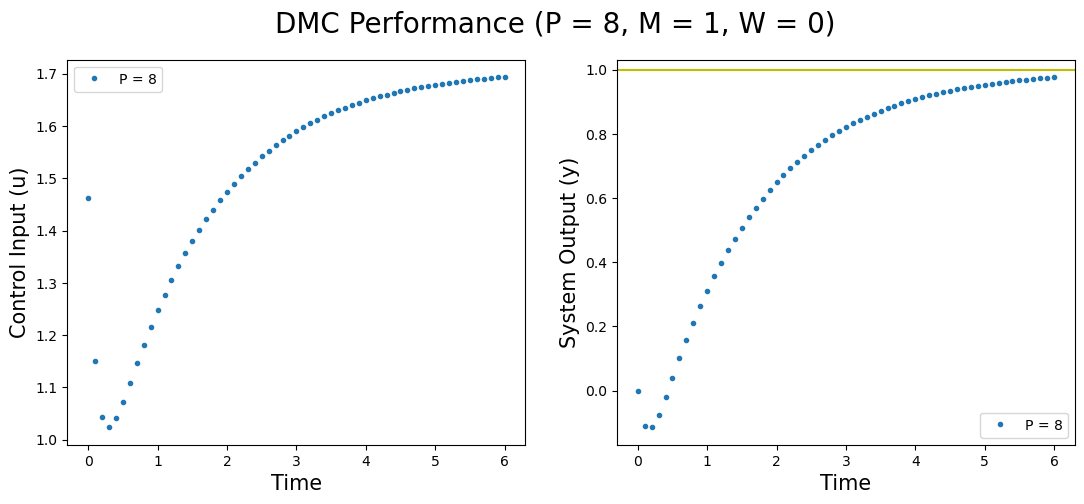

Execution time for P=8: 0.0040035247802734375 seconds


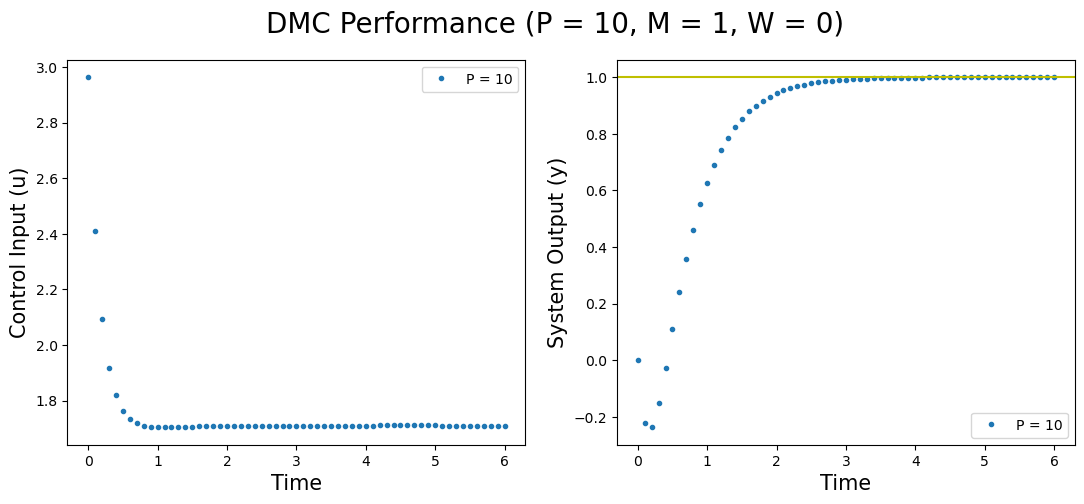

Execution time for P=10: 0.005005359649658203 seconds


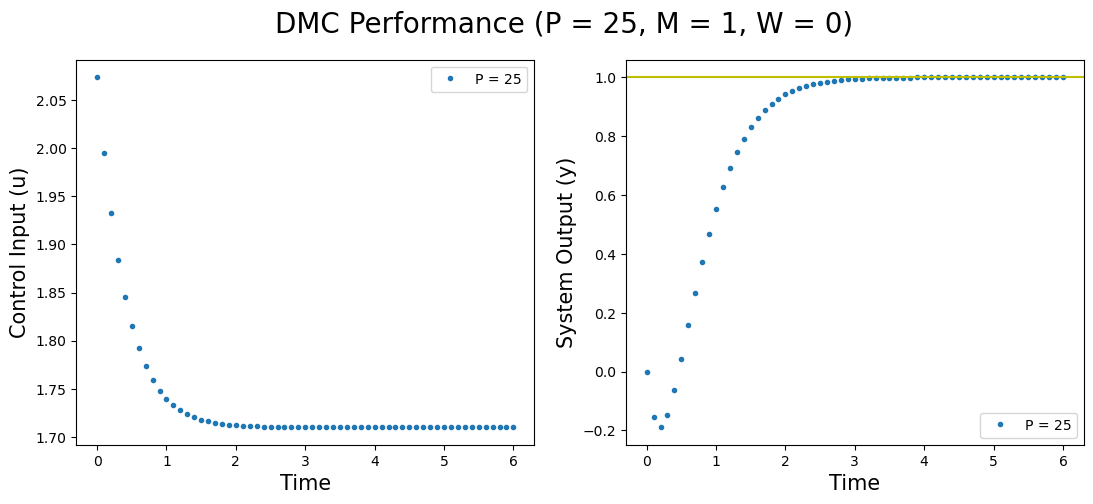

Execution time for P=25: 0.004004240036010742 seconds


In [142]:
P = [8, 10, 25] # prediction horizon
M = [1,2,5] # control horizon
w = [0,1] # weight

for P in P:
    W=w[0]*np.eye(M[0]) #weight matrix
    start_time = time.time()  # Record the start time of the iteration
    t, u, y = dmc_simulation(P, M[0], W)
    end_time = time.time()  # Record the end time of the iteration
    iteration_time = end_time - start_time  # Calculate the execution time of the iteration

    #Plotting
    plt.figure(figsize=(13, 5))
    plt.subplot(121)
    plt.plot(t, u[0],".", label=f'P = {P}')
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('Control Input (u)',fontsize=15)
    plt.legend()

    plt.subplot(122)
    plt.plot(t, y[0],".", label=f'P = {P}')
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('System Output (y)',fontsize=15)
    plt.axhline(y=1, color="y")
    plt.legend()

    plt.suptitle(f'DMC Performance (P = {P}, M = {M[0]}, W = {round(W[0][0])})',fontsize=20)
    plt.show()
    print(f"Execution time for P={P}: {iteration_time} seconds")

### Conclusion on Sweeping Parameter of Prediction Horizon P

From the observation on above plots and theories of DMC, the effect of changing the prediction horizon "P" in a Dynamic Matrix Control algorithm can be summarized as follows:
1. Prediction accuracy: Increasing the prediction horizon "P" improves the controller's ability to predict the system's future behavior. A larger "P" allows the controller to consider a longer range of future outputs, enabling it to make better-informed control decisions.


2. Control performance: A larger "P" can lead to better control performance, as the controller has more information about the system's future behavior. This allows it to make more appropriate control actions to bring the system output to the desired setpoint and shorten the time to reach setpoint (decreasing from 6s+ to 3s in this case). However, if "P" is too large, the controller may become overly focused on distant future events and neglect near-term control actions, leading to poor performance.


3. Computational complexity: Increasing "P" increases the size of the future step response matrix "S_f" and the inverse matrix calculation "(S_f.T * S_f) + W", leading to higher computational complexity. This may result in longer computation times for the DMC algorithm, which can be a concern in real-time applications with limited computational resources. The Execution times shown above indicate the time for the DMC loop with  different "P"s. An increasing trend in execution time can be observed.


4. Robustness to disturbances: A larger "P" can improve the controller's ability to handle disturbances and model uncertainties. By considering a longer range of future outputs, the controller is better equipped to make adjustments to the control actions in response to disturbances or model inaccuracies.


5. Oversensitivity to noise: A larger "P" may cause the controller to be more sensitive to noise or uncertainties in the system model. This can lead to unnecessary control actions, increased control effort, and potential instability in the system.

## Case B: Effect of M for M in [1, 2, 5], P = 25, w=0.

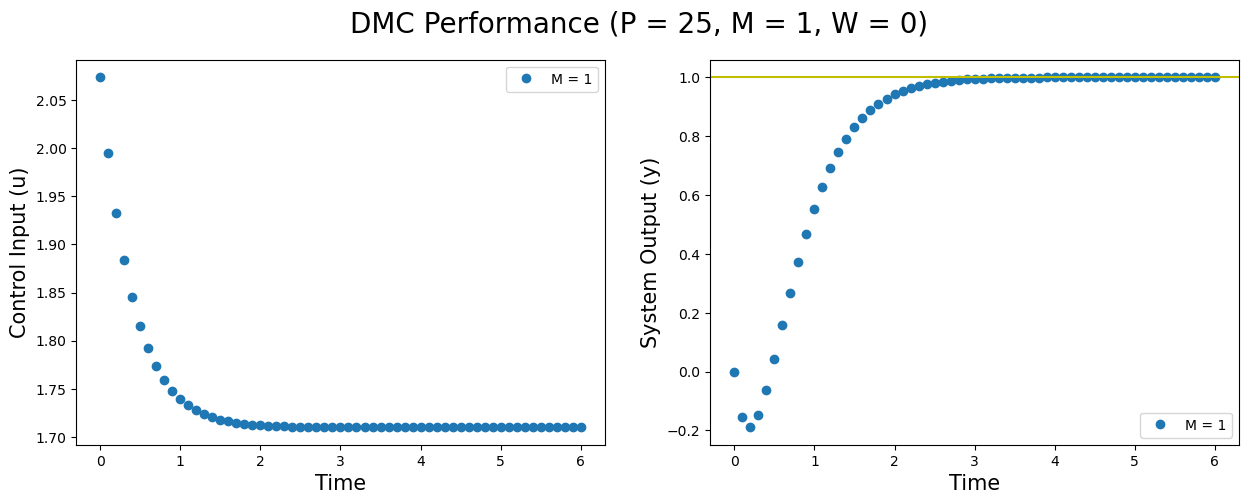

Execution time for M=1: 0.004003763198852539 seconds


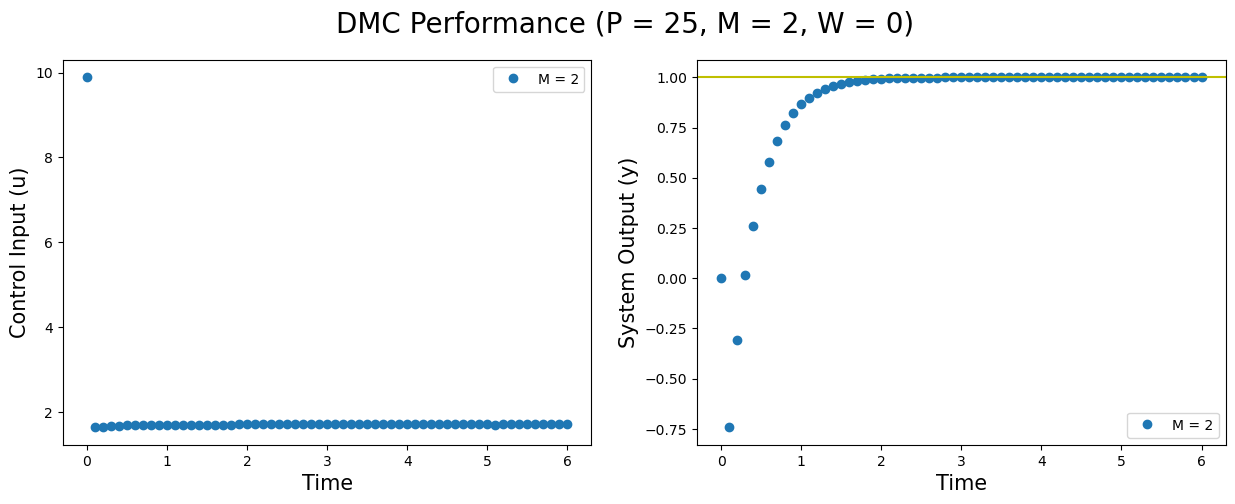

Execution time for M=2: 0.004004001617431641 seconds


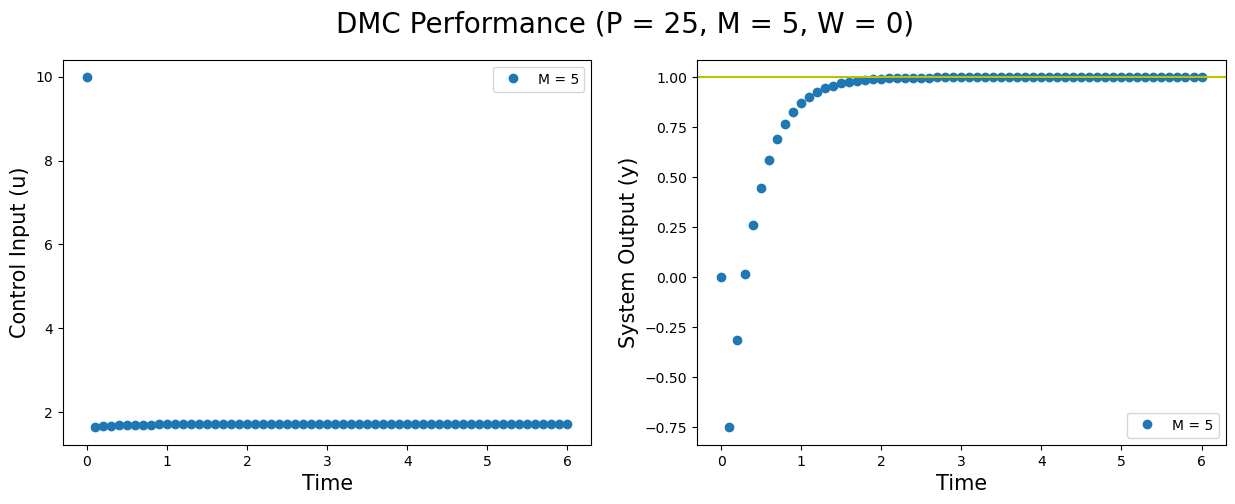

Execution time for M=5: 0.004004240036010742 seconds


In [143]:
P = [8, 10, 25] #prediction horizon
M = [1,2,5] #control horizon
w = [0,1] #weight

for M in M:
    W=w[0]*np.eye(M) #weight matrix
    start_time = time.time()  # Record the start time of the iteration
    t, u, y = dmc_simulation(P[2], M, W)
    end_time = time.time()  # Record the end time of the iteration
    iteration_time = end_time - start_time  # Calculate the execution time of the iteration

    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(t, u[0],"o", label=f'M = {M}')
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('Control Input (u)',fontsize=15)
    plt.legend()

    plt.subplot(122)
    plt.plot(t, y[0],"o", label=f'M = {M}')
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('System Output (y)',fontsize=15)
    plt.axhline(y=1, color="y")
    plt.legend()

    plt.suptitle(f'DMC Performance (P = {P[2]}, M = {M}, W = {round(W[0][0])})',fontsize=20)
    plt.show()
    print(f"Execution time for M={M}: {iteration_time} seconds")

### Conclusion on Sweeping Parameter of Control Horizon M

From the observation on above plots and theories of DMC, the effect of changing the control horizon M in a Dynamic Matrix Control algorithm can be summarized as follows:

1. Speed of response: Increasing "M" typically results in a faster response of the controller. The controller will make more aggressive control actions and rapid inputs to bring the system output closer to the setpoint in a shorter time (decreasing from ~3s to 1.8s in this case). However, this may also lead to more oscillations in the system response due to the increased aggressiveness.

2. Computational complexity: As "M" increases, the DMC algorithm's computational complexity increases. This is because the size of the future step response matrix "S_f" and the inverse matrix calculation "(S_f.T * S_f) + W" also increase, leading to longer computation times for the DMC algorithm. This might be a concern in real-time applications where computational resources are limited.

3. Robustness to model uncertainty and disturbances: A larger "M" can make the controller more robust to model uncertainties and disturbances. This is because the controller will be able to make more adjustments over a longer control horizon to correct the system's trajectory. However, if M is too large, the controller may become overly aggressive and sensitive to noise or model inaccuracies, leading to instability or poor performance.

4. Control effort: The control effort, which is the magnitude of the control input changes, may also be influenced by "M". A larger M can lead to more aggressive control actions and higher control effort. This might cause actuator saturation or increased wear and tear on the physical components of the system.


## Case C: Effect of W for M in [1, 2, 5], P = 25, w = I.

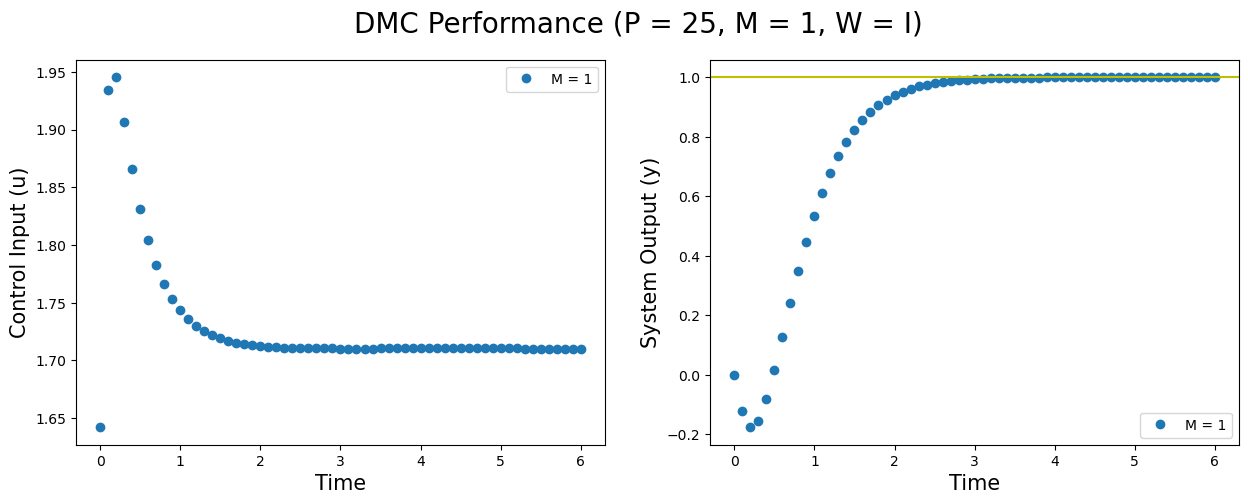

Execution time for M=1, W=I: 0.004004955291748047 seconds


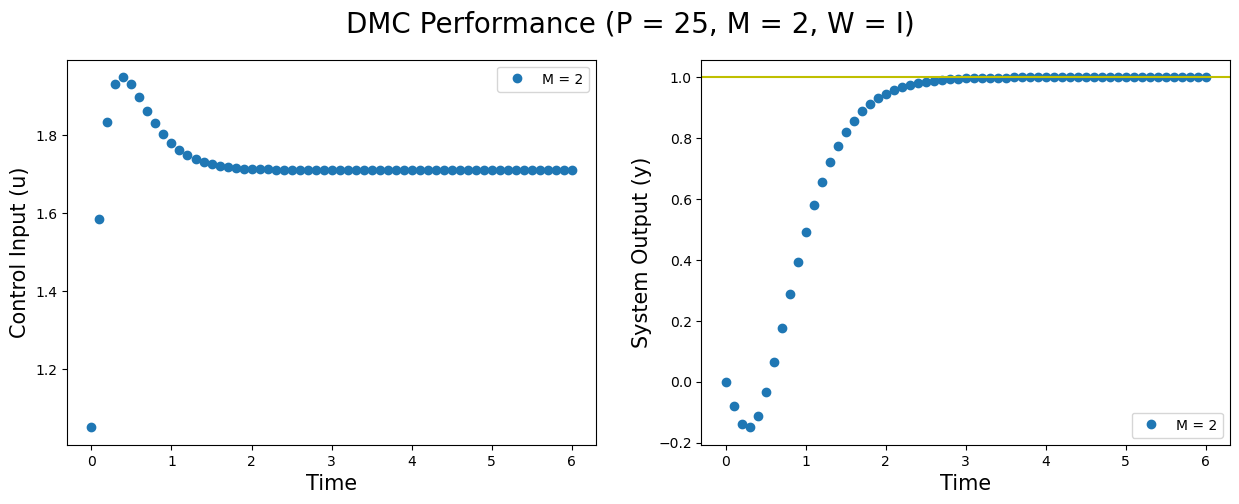

Execution time for M=2, W=I: 0.005005359649658203 seconds


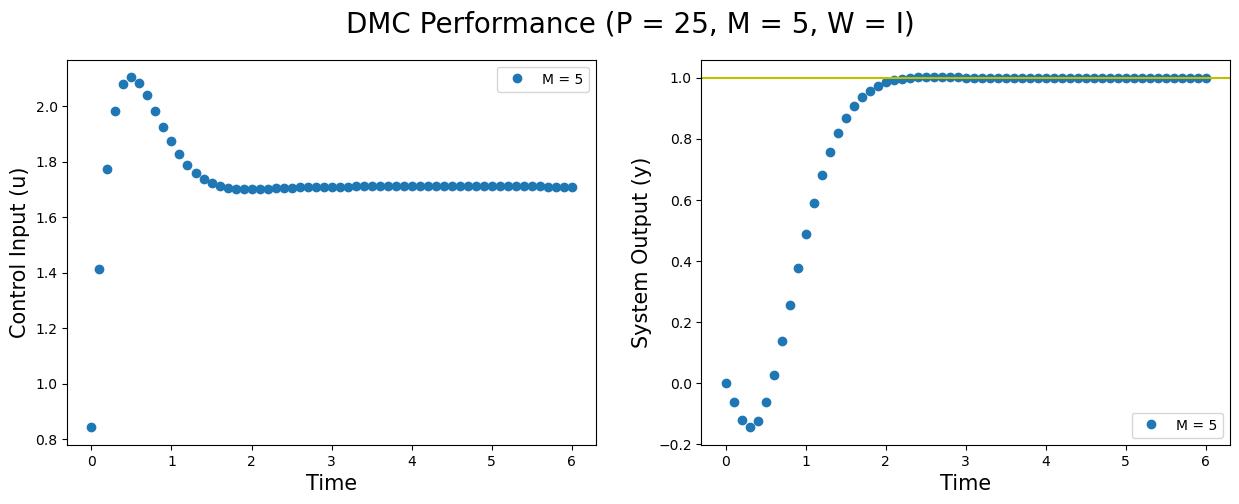

Execution time for M=5, W=I: 0.0050048828125 seconds


In [144]:
P = [8, 10, 25] #prediction horizon
M = [1,2,5] #control horizon
w = [0,1] #weight

for M in M:
    W=w[1]*np.eye(M) #weight matrix
    start_time = time.time()  # Record the start time of the iteration
    t, u, y = dmc_simulation(P[2], M, W)
    end_time = time.time()  # Record the end time of the iteration
    iteration_time = end_time - start_time  # Calculate the execution time of the iteration

    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(t, u[0],"o", label=f'M = {M}')
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('Control Input (u)',fontsize=15)
    plt.legend()

    plt.subplot(122)
    plt.plot(t, y[0],"o", label=f'M = {M}')
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('System Output (y)',fontsize=15)
    plt.axhline(y=1, color="y")
    plt.legend()

    plt.suptitle(f'DMC Performance (P = {P[2]}, M = {M}, W = {"I"})',fontsize=20)
    plt.show()
    print(f"Execution time for M={M}, W={'I'}: {iteration_time} seconds")

### Conclusion on Sweeping Parameter of weight W

From the observation on above plots and theories of DMC, the effect of changing the control horizon M in a Dynamic Matrix Control algorithm can be summarized as follows:

1. Control effort prioritization: Increasing the weight "W" from 0 to an identity matrix I emphasizes the minimization of control effort in the DMC optimization problem. This means that the algorithm will prioritize making smaller control actions to achieve the desired setpoint while reducing the overall control effort.

2. Smoother control actions: With a larger weight W, the DMC algorithm tends to produce smoother control actions, reducing abrupt changes in the control input (The dramatical changes on control inputs in case.b M=2 and 5 W = 0 vanished in this W=I case). This can be beneficial for systems that are sensitive to rapid changes in control signals or where minimizing wear and tear on actuators is important.

3. Trade-off between control performance and control effort: By increasing the weight W, the DMC algorithm balances the trade-off between control performance (i.e., achieving the desired setpoint) and control effort (i.e., minimizing the magnitude of control actions). This may result in a slightly slower convergence to the setpoint but with reduced control effort and smoother control actions (for example the M=2 and W=0 in case.B took ~1.9s to reach setpoint wherease M=2 and W=0 in this case took ~2.8s ).